# **Language Identification (LID) In 2 Ways: Naive Bayes with TF-IDF Features & BiLSTM**

**Introduction**

- **Task**: Build a LID model using python.

- **Dataset:** My model is trained and testing on 13 languages: English, German, Hindi, Spanish, French, Italian, Arabic, Dutch, Japanese, Portuguese, Tamil, Kannanda & Malayalam. NOTE: The last three (Tamil, Kannana and Malayalam) are codemixed with English and transliterated to Latin script.

I obtained a dataset for the first 10 languages in the list above from HuggingFace. I downloaded just the validation set (it faster to download that the 11K train split), which has 2.03K datapoints and then made my own train-val-test split from this set.

I obtained the Dravidian codemixed languages' data from [this GitHub repo](https://github.com/bharathichezhiyan/DravidianCodeMix-Dataset), which is an online documentation of Chakravarthi et al.'s (2022) DravidianCodeMix dataset [link text](https://link.springer.com/article/10.1007/s10579-022-09583-7).  

My dataset is split into a 60-20-20 train-test-val split, with *equal distribution across the 13 languages (*in some cases, some languagesh have 1 more datapoint than the others because an exact even split was not possible).  

I chose the HuggingFace dataset because it was easily accessible and contained a good distribution of languages across different language families and also, from different written scripts. This allows my LID model to learn a diverse range of languages as well as differentiating between similar languages like Spanish and Italian.

I chose 3 Dravidian Codemixed languages to observe how a word-order-free approach like Naive Bayes would handle documents that contain prominent tokens from another language in the dataset (English) while the majority of the content in a Tamil document remains as transliterated Tamil, whose popular ngrams are not similar to those in English.

While the data are preprocessed to remove punctuation marks, they are not stemmed or lemmatized to preserve meaningful morphemes in different languages.

- **Evaluation Strategy:** Both models are tested on the test set; a classification report is printed, showing the precision, recall and F1 score by language and an overall accuracy score. Considering the dataset is equally distributed across languages, I take the accuracy score to be a fair representation of the model's performance on the test set. The F1 score shows a balance between precision and recall for each language.

I also print out some misclassified examples to see cases where the model made errors.

- **How To Run This Code & Access The Data:**

Colab Link: https://colab.research.google.com/drive/1gJCn-QmCaGOfbQtcmt0J__QKxn5l1ezh?usp=sharing
If using the Colab link to run this file, you may need to download the datasets from my GitHub repo below to run it fully.

GitHub Repo: https://github.com/manishavenkat/Language-Identification
This repo contains this .ipynb as well as the train/val/test splits used for both models. It also contains the full codemixed datasets from which random documents were taken to create my train/val/test splits.

**Section 1: Naive Bayes Classifier with TF-IDF Features**

This approach was inspired by [Gebre et al.'s](https://aclanthology.org/W13-1728/) (2013) *Improving Native Language Identification with TF-IDF Weighting.*

TF-IDF was used to see how unique an ngram was not just to each document but to each language, because certain ngrams are common across similar languages like Spanish and Portuguese. There are similar ngrams in transliterated Tamil and Malayalam as well. My working hypothesis was that TF-IDF would help better distinguish between similar languages than a bag-of-words approach, which does not normalize ngrams by language class.

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import re

In [2]:
access_token = 'ENTER YOUR ACCESS TOKEN HERE' #only if you want to redownload the dataset from HuggingFace

In [3]:
splits = {'train': 'train.csv', 'validation': 'validation.csv', 'test': 'test.csv'}
df = pd.read_csv("hf://datasets/Amani27/massive_translation_dataset/" + splits["validation"]) #downloading the smallest set for faster download
print(df.head)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


<bound method NDFrame.head of          id       split                                              en_US  \
0        11  validation                         turn the lights off please   
1        17  validation                         dim the lights in the hall   
2        24  validation                                 make a room darker   
3        26  validation                                     clean the flat   
4        30  validation  cleaning is good dust is so bad do now your ma...   
...     ...         ...                                                ...   
2028  17121  validation                              report any new emails   
2029  17137  validation                how many unread messages have i got   
2030  17140  validation            please respond to the email i just read   
2031  17153  validation                            did bert write me today   
2032  17167  validation                        what's the address for alex   

                                 

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# tamil = '/content/drive/My Drive/tamil_sentiment_full_train.csv'
# mal = '/content/drive/My Drive/mal_full_sentiment_train.csv'
# kan = '/content/drive/My Drive/kannada_sentiment_train.csv'

In [6]:
df_tamil = pd.read_csv('/content/drive/My Drive/tamil_sentiment_full_train.csv', encoding='latin-1')
df_kan = pd.read_csv('/content/drive/My Drive/kannada_sentiment_train.csv', encoding='latin-1')
df_mal = pd.read_csv('/content/drive/My Drive/mal_full_sentiment_train.csv', encoding='latin-1')

<ipython-input-6-8d6a96bb47b8>:1: DtypeWarning: Columns (3,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,29,32,35,37,39,44,57) have mixed types. Specify dtype option on import or set low_memory=False.
  df_tamil = pd.read_csv('/content/drive/My Drive/tamil_sentiment_full_train.csv', encoding='latin-1')


In [7]:
# Concatenate the first two columns of the three dataframes lengthwise
df_codemixed = pd.concat([df_tamil.iloc[:, :2], df_kan.iloc[:, :2], df_mal.iloc[:, :2]], axis=0)
print(df_codemixed.head)

<bound method NDFrame.head of                                                     text   language
0                  First like button vijay setupati fans      tamil
1             Vetri ne dhanusha pudiche thongitu iru....      tamil
2      Ithu romba naal ku munnadi Short film'a pathat...      tamil
3                   Trending no1 in srilanka.... june 16      tamil
4                          Maja thala marana  mass thala      tamil
...                                                  ...        ...
15689  Sheriyaa.. Siddique Lalettante othiri kali ner...  malayalam
15690  Adutha vishunu aduthu vekkam .... Assal padakk...  malayalam
15691  Teaserum trailer kandapol nyn vecharichu poyen...  malayalam
15692  njan ee song kett maduthilla .athrakku ishtta ...  malayalam
15693     Ente tamil friend nte caller tone aanu ee patu  malayalam

[57050 rows x 2 columns]>


In [8]:
# Remove punctuation from text
df_codemixed[df_codemixed.columns[0]] = df_codemixed[df_codemixed.columns[0]].apply(lambda x: re.sub(r'[^\w\s]', '', str(x)))
print(df_codemixed.head)

# # Remove entries with 'à, ®, Ã'
df_codemixed = df_codemixed[~df_codemixed[df_codemixed.columns[0]].str.contains('à®', na=False)]
# df_codemixed.to_csv('codemixed_data.csv', index=False)
print(df_codemixed.head)

<bound method NDFrame.head of                                                     text   language
0                  First like button vijay setupati fans      tamil
1                 Vetri ne dhanusha pudiche thongitu iru      tamil
2      Ithu romba naal ku munnadi Short filma pathath...      tamil
3                       Trending no1 in srilanka june 16      tamil
4                          Maja thala marana  mass thala      tamil
...                                                  ...        ...
15689  Sheriyaa Siddique Lalettante othiri kali nerit...  malayalam
15690  Adutha vishunu aduthu vekkam  Assal padakkam a...  malayalam
15691  Teaserum trailer kandapol nyn vecharichu poyen...  malayalam
15692  njan ee song kett maduthilla athrakku ishtta l...  malayalam
15693     Ente tamil friend nte caller tone aanu ee patu  malayalam

[57050 rows x 2 columns]>
<bound method NDFrame.head of                                                     text   language
0                  First like

In [9]:
# Create a single row with language label
def create_labeled_data(row):
    all_langs = []
    for lang in languages:
        if pd.notna(row[lang]):
           all_langs.append(pd.Series({
                'text': row[lang],
                'language': lang,
                'id': row['id']
            }))
    return pd.concat(all_langs, axis=0)

languages = ['en_US', 'de_DE', 'hi_IN', 'es_ES', 'fr_FR',
             'it_IT', 'ar_SA', 'nl_NL', 'ja_JP', 'pt_PT']

# Melt the dataframe to lengthwise format
corpus_df = pd.melt(df,
                    id_vars=['id'],
                    value_vars=languages,
                    var_name='language',
                    value_name='text')

# remove rows with NaN text
corpus_df = corpus_df.dropna(subset=['text'])

# reset index
corpus_df = corpus_df.reset_index(drop=True)

print(corpus_df.head)
# print(corpus_df['language'].unique())

<bound method NDFrame.head of           id language                                               text
0         11    en_US                         turn the lights off please
1         17    en_US                         dim the lights in the hall
2         24    en_US                                 make a room darker
3         26    en_US                                     clean the flat
4         30    en_US  cleaning is good dust is so bad do now your ma...
...      ...      ...                                                ...
20325  17121    pt_PT                    reportar quaisquer emails novos
20326  17137    pt_PT               quantas mensagens não lidas tenho eu
20327  17140    pt_PT               responder ao email que acabei de ler
20328  17153    pt_PT            o alberto escreveu-me alguma coisa hoje
20329  17167    pt_PT                     qual é o endereço do alexandre

[20330 rows x 3 columns]>


In [10]:
corpus_df = corpus_df.drop('id', axis=1)
print(corpus_df.head)
# concatenate df_codemixed to corpus_df lengthwise
corpus_df = pd.concat([corpus_df, df_codemixed], axis=0)
print(corpus_df['language'].unique())
# convert corpus_df to utf-8 encoding
corpus_df['text'] = corpus_df['text'].str.encode('utf-8', 'ignore').str.decode('utf-8')


<bound method NDFrame.head of       language                                               text
0        en_US                         turn the lights off please
1        en_US                         dim the lights in the hall
2        en_US                                 make a room darker
3        en_US                                     clean the flat
4        en_US  cleaning is good dust is so bad do now your ma...
...        ...                                                ...
20325    pt_PT                    reportar quaisquer emails novos
20326    pt_PT               quantas mensagens não lidas tenho eu
20327    pt_PT               responder ao email que acabei de ler
20328    pt_PT            o alberto escreveu-me alguma coisa hoje
20329    pt_PT                     qual é o endereço do alexandre

[20330 rows x 2 columns]>
['en_US' 'de_DE' 'hi_IN' 'es_ES' 'fr_FR' 'it_IT' 'ar_SA' 'nl_NL' 'ja_JP'
 'pt_PT' 'tamil' 'kannanda' 'malayalam']


In [11]:
language_mapping = {
    'en_US': 'english',
    'de_DE': 'german',
    'hi_IN': 'hindi',
    'es_ES': 'spanish',
    'fr_FR': 'french',
    'it_IT': 'italian',
    'ar_SA': 'arabic',
    'nl_NL': 'dutch',
    'ja_JP': 'japanese',
    'pt_PT': 'portuguese'
}

corpus_df['language'] = corpus_df['language'].replace(language_mapping)
print(corpus_df['language'].unique())


['english' 'german' 'hindi' 'spanish' 'french' 'italian' 'arabic' 'dutch'
 'japanese' 'portuguese' 'tamil' 'kannanda' 'malayalam']


In [12]:
# concatenate df_codemixed and corpus_df lengthwise
corpus_df = pd.concat([corpus_df, df_codemixed], axis=0)
print(corpus_df['language'].unique())

['english' 'german' 'hindi' 'spanish' 'french' 'italian' 'arabic' 'dutch'
 'japanese' 'portuguese' 'tamil' 'kannanda' 'malayalam']


In [13]:
# equal datapoints across all languages
min_samples_per_language = corpus_df.groupby('language')['text'].count().min()
balanced_corpus_df = corpus_df.groupby('language').apply(lambda x: x.sample(min_samples_per_language, random_state=42)).reset_index(drop=True)

# split data into train, validation, and test sets (60-20-20 split)
train_df, temp_df = train_test_split(balanced_corpus_df, test_size=0.4, stratify=balanced_corpus_df['language'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['language'], random_state=42)

# print the distribution of datapoints per language in each split
print("Train Data Distribution:")
print(train_df['language'].value_counts())
print("\nValidation Data Distribution:")
print(val_df['language'].value_counts())
print("\nTest Data Distribution:")
print(test_df['language'].value_counts())

# # save
# train_df.to_csv('train_data.csv', index=False)
# val_df.to_csv('validation_data.csv', index=False)
# test_df.to_csv('test_data.csv', index=False)


Train Data Distribution:
language
dutch         1220
hindi         1220
kannanda      1220
japanese      1220
german        1220
malayalam     1220
spanish       1220
tamil         1220
english       1220
arabic        1220
portuguese    1219
french        1219
italian       1219
Name: count, dtype: int64

Validation Data Distribution:
language
arabic        407
spanish       407
italian       407
tamil         407
german        407
japanese      407
portuguese    407
french        407
malayalam     406
english       406
kannanda      406
hindi         406
dutch         406
Name: count, dtype: int64

Test Data Distribution:
language
hindi         407
english       407
french        407
italian       407
kannanda      407
dutch         407
malayalam     407
portuguese    407
arabic        406
tamil         406
german        406
spanish       406
japanese      406
Name: count, dtype: int64


In [14]:
# uncomment and use this in case HF-pandas download doesn't work
train_set = '/content/drive/My Drive/train_data.csv'
val_set = '/content/drive/My Drive/validation_data.csv'
test_set = '/content/drive/My Drive/test_data.csv'

In [15]:
class TFIDFLanguageIdentifier:
    def __init__(self, ngram_range=(1,3)): #using 1 to 3-grams
        self.vectorizer = TfidfVectorizer(analyzer='char',
                                          ngram_range=ngram_range,
                                          use_idf=True)
        self.classifier = MultinomialNB()

    def fit(self, X, y):
        X_tfidf = self.vectorizer.fit_transform(X)
        self.classifier.fit(X_tfidf, y)

    def predict(self, X):
        X_tfidf = self.vectorizer.transform(X)
        return self.classifier.predict(X_tfidf)

    def predict_proba(self, X):
        X_tfidf = self.vectorizer.transform(X)
        return self.classifier.predict_proba(X_tfidf)

    def get_top_features(self, language, n=10):
        feature_names = self.vectorizer.get_feature_names_out()
        tfidf_scores = self.vectorizer.idf_
        language_idx = list(self.classifier.classes_).index(language)
        class_prob = self.classifier.feature_log_prob_[language_idx]
        top_indices = class_prob.argsort()[-n:][::-1]
        return [(feature_names[i], tfidf_scores[i]) for i in top_indices]

In [16]:
# initialize and train the model
lid_model = TFIDFLanguageIdentifier()
lid_model.fit(train_df['text'], train_df['language'])

In [17]:
# evaluate the model
y_pred = lid_model.predict(test_df['text'])
print(classification_report(test_df['language'], y_pred))


              precision    recall  f1-score   support

      arabic       1.00      0.97      0.98       406
       dutch       0.96      0.96      0.96       407
     english       0.82      0.98      0.89       407
      french       0.98      0.98      0.98       407
      german       0.96      0.97      0.97       406
       hindi       1.00      1.00      1.00       407
     italian       0.92      0.98      0.95       407
    japanese       1.00      0.98      0.99       406
    kannanda       0.97      0.73      0.84       407
   malayalam       0.79      0.71      0.75       407
  portuguese       0.98      0.94      0.96       407
     spanish       0.95      0.96      0.95       406
       tamil       0.63      0.73      0.68       406

    accuracy                           0.91      5286
   macro avg       0.92      0.91      0.91      5286
weighted avg       0.92      0.91      0.91      5286



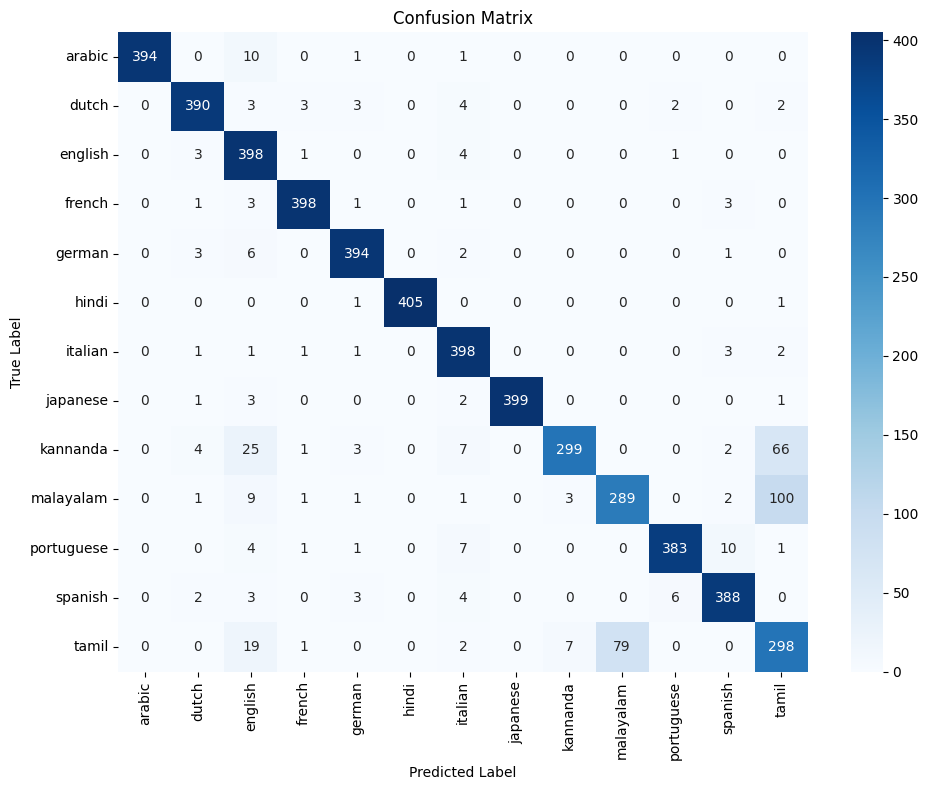

In [18]:
# plot confusion matrix
cm = confusion_matrix(test_df['language'], y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d',cmap='Blues',
            xticklabels=lid_model.classifier.classes_,
            yticklabels=lid_model.classifier.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

In [19]:
# get misclassified examples
X_test = test_df['text']
y_test = test_df['language']
y_pred_proba = lid_model.predict_proba(X_test)
misclassified = X_test[y_test != y_pred]
misclassified_true = y_test[y_test != y_pred]
misclassified_pred = y_pred[y_test != y_pred]
misclassified_proba = y_pred_proba[y_test != y_pred]

# 5 misclassified examples
print("\n5 Misclassified Examples:")
for i in range(min(5, len(misclassified))):
    print(f"\nExample {i+1}:")
    print(f"Text: {misclassified.iloc[i][:100]}...")  # Show first 100 characters
    print(f"True Language: {misclassified_true.iloc[i]}")
    print(f"Predicted Language: {misclassified_pred[i]}")
    print("Class Probabilities:")
    for lang, prob in zip(lid_model.classifier.classes_, misclassified_proba[i]):
        print(f"  {lang}: {prob:.4f}")


5 Misclassified Examples:

Example 1:
Text: Inghakk prayam 68ann  Prayam verum akangall enn thelikunna nadana vismayam...
True Language: malayalam
Predicted Language: tamil
Class Probabilities:
  arabic: 0.0000
  dutch: 0.0009
  english: 0.0006
  french: 0.0001
  german: 0.0007
  hindi: 0.0000
  italian: 0.0001
  japanese: 0.0000
  kannanda: 0.0155
  malayalam: 0.3643
  portuguese: 0.0001
  spanish: 0.0002
  tamil: 0.6174

Example 2:
Text: ààµààµààà à¹ààààààµààà àªà¾ààààà àµàààààà àªààà  àà¾àà_àà¾àà²à àµààààààààààà ààààà¾ààààààààààà àà¾àª...
True Language: tamil
Predicted Language: malayalam
Class Probabilities:
  arabic: 0.0000
  dutch: 0.0000
  english: 0.0000
  french: 0.0000
  german: 0.0000
  hindi: 0.0000
  italian: 0.0000
  japanese: 0.0000
  kannanda: 0.0009
  malayalam: 0.8251
  portuguese: 0.0000
  spanish: 0.0000
  tamil: 0.1739

Example 3:
Text: trailer  verunathin munbe ore kariym parayam   ee onam ettanum pillerum agade edukkuva...
True Language: malayalam
Predicted Lang

**BiLSTM Model using trigrams**

This approach was inspired by [Toftrup et al.'s](https://aclanthology.org/2021.eacl-srw.6/) (2021) *A reproduction of Apple’s bi-directional LSTM models for language identification in short strings.*

How much does word-order matter? I trained and tested a biLSTM model, better-equiped to handle sequential data like written text. I found that it improves on the above Naive Bayes classifier by only 0.01% on my 13-class dataset.

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from tqdm import tqdm

In [21]:
# create character n-grams
def create_char_ngrams(text, n=3): #change to bigrams or unigrams if needed
    return [text[i:i+n] for i in range(len(text)-n+1)]

In [22]:
# create vocabulary of character n-grams
def create_ngram_vocabulary(texts, n=2, max_ngrams=10000):
    ngram_counts = Counter()
    for text in texts:
        ngram_counts.update(create_char_ngrams(text, n))
    return ['<PAD>', '<UNK>'] + [ngram for ngram, _ in ngram_counts.most_common(max_ngrams - 2)]


In [23]:
# combine all texts for vocabulary creation
all_texts = pd.concat([train_df['text'], val_df['text'], test_df['text']])

# create vocabulary of character n-grams
n = 2
vocab = create_ngram_vocabulary(all_texts, n)
ngram_to_idx = {ngram: idx for idx, ngram in enumerate(vocab)}

# encode labels
label_encoder = LabelEncoder()
label_encoder.fit(train_df['language'])


LabelEncoder()

In [24]:
# data loader prep for character n-grams
class CharNgramDataset(Dataset):
    def __init__(self, texts, labels, ngram_to_idx, n=2, max_length=120):
        self.texts = texts
        self.labels = label_encoder.transform(labels)
        self.ngram_to_idx = ngram_to_idx
        self.n = n
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        ngrams = create_char_ngrams(self.texts.iloc[idx], self.n)
        encoded = [self.ngram_to_idx.get(ngram, self.ngram_to_idx['<UNK>']) for ngram in ngrams[:self.max_length]]
        encoded = encoded + [self.ngram_to_idx['<PAD>']] * (self.max_length - len(encoded))
        return torch.tensor(encoded), torch.tensor(self.labels[idx])


In [25]:
# create datasets and dataloaders
train_dataset = CharNgramDataset(train_df['text'], train_df['language'], ngram_to_idx, n)
val_dataset = CharNgramDataset(val_df['text'], val_df['language'], ngram_to_idx, n)
test_dataset = CharNgramDataset(test_df['text'], test_df['language'], ngram_to_idx, n)

batch_size = 32 # hparam
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


In [26]:
# biLSTM model
class CharNgramBiLSTM(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, output_size, num_layers=1, dropout=0.2):
        super(CharNgramBiLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers=num_layers, batch_first=True, bidirectional=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size * 2, output_size)  # * 2 for bidirectional

    def forward(self, x):
        embedded = self.embedding(x)
        output, (hidden, cell) = self.lstm(embedded)

        # concatenate the final hidden states from both directions
        hidden_cat = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        return self.fc(hidden_cat)


In [27]:
# hparams
vocab_size = len(vocab)
embed_size = 50
hidden_size = 128
output_size = len(label_encoder.classes_)
num_layers = 2
dropout = 0.2
learning_rate = 0.001
num_epochs = 10

In [28]:
# initialize the model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CharNgramBiLSTM(vocab_size, embed_size, hidden_size, output_size, num_layers, dropout).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [29]:
# training loop
for epoch in tqdm(range(num_epochs)):
    model.train()
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # evalutaion
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    val_loss /= len(val_loader)
    accuracy = correct / len(val_dataset)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Accuracy: {accuracy:.4f}')


 10%|█         | 1/10 [00:07<01:09,  7.70s/it]

Epoch 1/10, Train Loss: 1.2043, Val Loss: 0.6284, Val Accuracy: 0.7777


 20%|██        | 2/10 [00:13<00:52,  6.61s/it]

Epoch 2/10, Train Loss: 0.4933, Val Loss: 0.4531, Val Accuracy: 0.8494


 30%|███       | 3/10 [00:19<00:45,  6.53s/it]

Epoch 3/10, Train Loss: 0.3114, Val Loss: 0.3492, Val Accuracy: 0.8865


 40%|████      | 4/10 [00:25<00:37,  6.20s/it]

Epoch 4/10, Train Loss: 0.2175, Val Loss: 0.2943, Val Accuracy: 0.9065


 50%|█████     | 5/10 [00:30<00:29,  5.89s/it]

Epoch 5/10, Train Loss: 0.1573, Val Loss: 0.2978, Val Accuracy: 0.9098


 60%|██████    | 6/10 [00:36<00:23,  5.81s/it]

Epoch 6/10, Train Loss: 0.1306, Val Loss: 0.2653, Val Accuracy: 0.9171


 70%|███████   | 7/10 [00:42<00:17,  5.73s/it]

Epoch 7/10, Train Loss: 0.1016, Val Loss: 0.2643, Val Accuracy: 0.9188


 80%|████████  | 8/10 [00:50<00:13,  6.53s/it]

Epoch 8/10, Train Loss: 0.0797, Val Loss: 0.2563, Val Accuracy: 0.9279


 90%|█████████ | 9/10 [00:58<00:06,  6.86s/it]

Epoch 9/10, Train Loss: 0.0699, Val Loss: 0.2601, Val Accuracy: 0.9245


100%|██████████| 10/10 [01:03<00:00,  6.36s/it]

Epoch 10/10, Train Loss: 0.0490, Val Loss: 0.2587, Val Accuracy: 0.9296


In [30]:
# save the model
def save_model(model, filepath):
    torch.save(model.state_dict(), filepath)
    print(f"Model saved to {filepath}")

In [31]:
# load the model to test again if necessary
def load_model(model, filepath):
    model.load_state_dict(torch.load(filepath))
    model.eval()
    print(f"Model loaded from {filepath}")
    return model

In [32]:
# Save the trained model
save_model(model, 'bilstm_lid.pth')

Model saved to bilstm_lid.pth


In [33]:
loaded_model = CharNgramBiLSTM(vocab_size, embed_size, hidden_size, output_size, num_layers, dropout).to(device)
loaded_model = load_model(loaded_model, 'bilstm_lid.pth')

Model loaded from bilstm_lid.pth


<ipython-input-31-080fcf4378bf>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filepath))


In [34]:
# get predictions and true labels
def get_predictions(model, data_loader):
    model.eval()
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            predictions = output.argmax(dim=1)
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(target.cpu().numpy())
    return np.array(all_predictions), np.array(all_labels)


In [35]:
# print misclassified examples
def print_misclassified_examples(texts, true_labels, predicted_labels, n=5):
    misclassified = np.where(true_labels != predicted_labels)[0]
    np.random.shuffle(misclassified)

    # the index shouldn't exceed the bounds of texts
    for idx in misclassified[:n]:
        if idx < len(texts):  # check if index is within bounds
            print(f"Text: {texts[idx]}")
            print(f"True label: {label_encoder.inverse_transform([true_labels[idx]])[0]}")
            print(f"Predicted label: {label_encoder.inverse_transform([predicted_labels[idx]])[0]}")
            print()


In [36]:
# Evaluate on test set
test_predictions, test_true_labels = get_predictions(loaded_model, test_loader)

In [37]:
# Classification report
print("Classification Report:")
print(classification_report(test_true_labels, test_predictions, target_names=label_encoder.classes_))


Classification Report:
              precision    recall  f1-score   support

      arabic       0.96      0.96      0.96       406
       dutch       0.95      0.95      0.95       407
     english       0.85      0.97      0.91       407
      french       0.98      0.93      0.95       407
      german       0.97      0.96      0.96       406
       hindi       0.98      0.98      0.98       407
     italian       0.97      0.96      0.96       407
    japanese       0.96      0.94      0.95       406
    kannanda       0.88      0.87      0.87       407
   malayalam       0.83      0.90      0.87       407
  portuguese       0.90      0.95      0.92       407
     spanish       0.94      0.89      0.92       406
       tamil       0.90      0.79      0.84       406

    accuracy                           0.93      5286
   macro avg       0.93      0.93      0.93      5286
weighted avg       0.93      0.93      0.93      5286



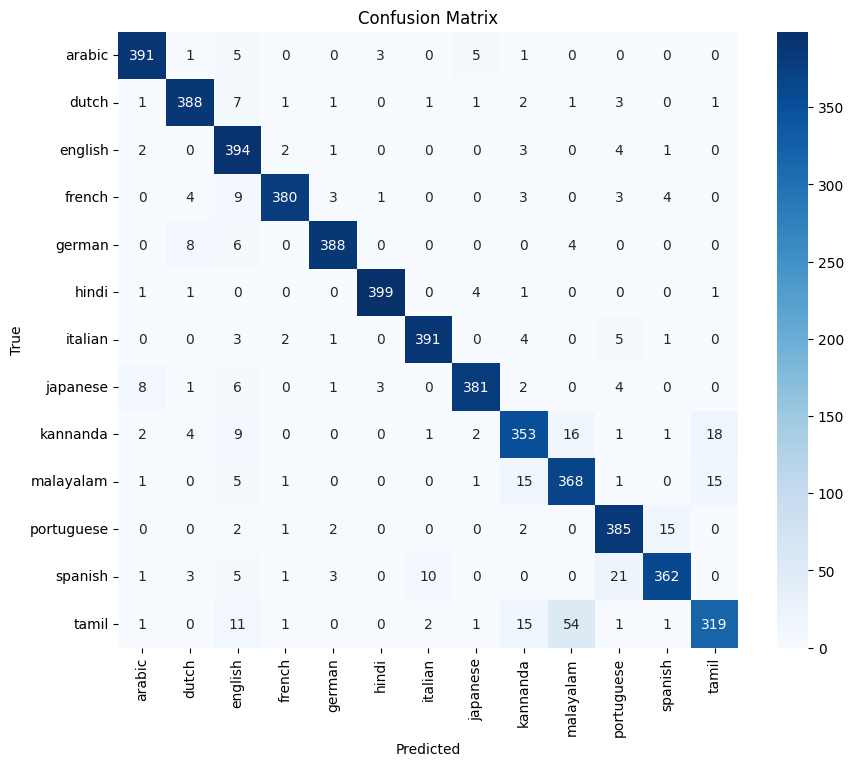

In [38]:
# confusion matrix
cm = confusion_matrix(test_true_labels, test_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [40]:
# evaluate on test set
model.eval()
test_loss = 0
correct = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss += criterion(output, target).item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

test_loss /= len(test_loader)
accuracy = correct / len(test_dataset)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.4f}')


Test Loss: 0.2706, Test Accuracy: 0.9268
